# Non technical summary


## Context

To validate the effectiveness of our workflow in accomplishing our goal, our first milestone is to infer where, when, and what each user is likely to purchase: 


![tennis1](./NextAI-High-Level-Model.pdf.png)


We’ve started extracting features from a dataset of ~2.5 Million transactions, consisting of ~ 92K products, across 800 households. A gradient-boosted decision tree (XGBoost) classification algorithm has been used to classify retailers based on customer shopping preferences according to features such as: customer_ID, age, and income.

## Results:

We performed a features importance analysis in XGBoost to understand which factors have the highest impact on what store a specific household is most likely to do their shopping.  

Through these results, we can infer that the most important feature for households are:
1. Store location 
2. Product Price Points
3. Retailer Discounts

## Perspectives
Training our algorithm has been extremely slow so we could only use 1% of the data due to time limitations.  The NextAI opportunity would provide us with the resources required to accelerate our progress.  Once we’re confident in our model and workflow, we plan to leverage our relationships with executives at Canadian financial institutions to run a pilot with live data. We’re currently using Open Bank Project (https://www.openbankproject.com/) to make it easy for potential bank partners to integrate with us. 

# Technical Notebook

## Setup

In [1]:
# Import libraries

import pandas as pd
import numpy as np
print(__doc__)
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     random_projection)
import hdbscan
import seaborn as sns
%matplotlib inline
import matplotlib
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import pylab
from matplotlib import pyplot
from IPython.display import display, HTML
import glob
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import cross_val_score


Automatically created module for IPython interactive environment


/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read input files into dataframes 

transactions = pd.read_csv('./inputcompjour/transaction_data.csv', header=0)
demographics = pd.read_csv('./inputcompjour/hh_demographic.csv', header=0)
campaign_desc = pd.read_csv('./inputcompjour/campaign_desc.csv', header=0)
campaign_table = pd.read_csv('./inputcompjour/campaign_table.csv', header=0)
coupon = pd.read_csv('./inputcompjour/coupon.csv', header=0)
coupon_redempt = pd.read_csv('./inputcompjour/coupon_redempt.csv', header=0)
product = pd.read_csv('./inputcompjour/product.csv', header=0)
causal_data = pd.read_csv('./inputcompjour/causal_data.csv', header=0)

## Features exploration

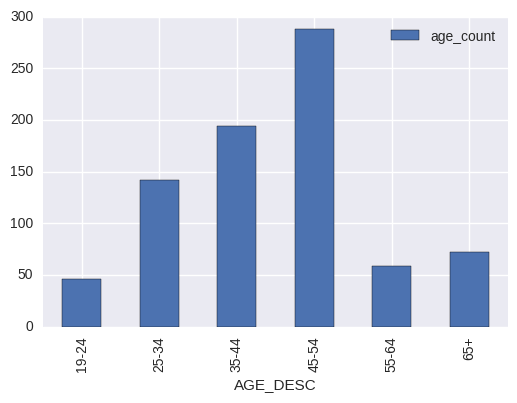

In [51]:
# Age distribution

age_dist = demographics[['AGE_DESC', 'household_key']]
age_dist = age_dist.groupby('AGE_DESC').count()
age_dist = age_dist.rename(columns={'household_key':'age_count'})
age_dist.plot(kind='bar')

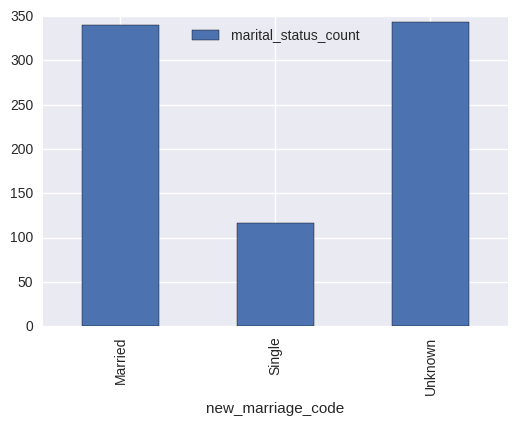

In [52]:
# Marital status distribution

demographics['new_marriage_code'] =demographics.MARITAL_STATUS_CODE.map({
    'A': 'Married',
    'B': 'Single',
    'U': 'Unknown'
})
marriage_dist = demographics[['new_marriage_code', 'household_key']]
marriage_dist = marriage_dist.groupby('new_marriage_code').count()
marriage_dist = marriage_dist.rename(columns={'household_key':'marital_status_count'})
marriage_dist.plot(kind='bar')



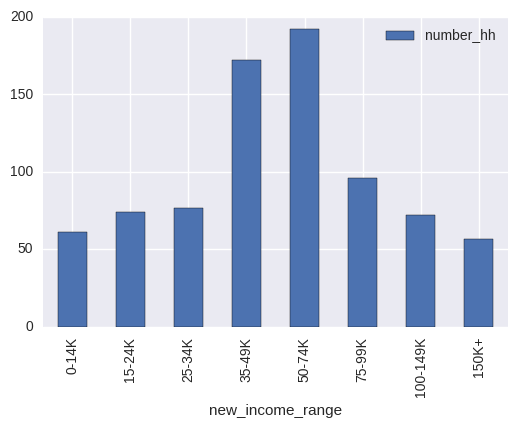

In [55]:
# Income distribution

demographics['new_income_range'] = demographics.INCOME_DESC.map({
    'Under 15K': '0-14K',
    '15-24K': '15-24K',
    '25-34K': '25-34K',
    '35-49K': '35-49K',
    '50-74K': '50-74K',
    '75-99K': '75-99K',
    '100-124K': '100-149K',
    '125-149K': '100-149K',
    '150-174K': '150K+',
    '175-199K': '150K+',
    '200-249K': '150K+',
    '250K+': '150K+'
})

income_dist = demographics[['new_income_range', 'household_key']]
income_dist = income_dist.groupby('new_income_range').count()
income_dist = income_dist.rename(columns={'household_key':'number_hh'})
income_dist = income_dist.reindex(['0-14K','15-24K','25-34K','35-49K','50-74K','75-99K','100-149K','150K+'])
income_dist.plot(kind='bar')

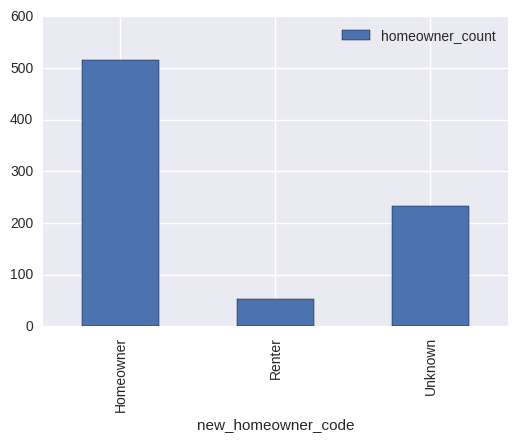

In [60]:
# Home ownership distribution

demographics['new_homeowner_code'] = demographics.HOMEOWNER_DESC.map({
    'Probable Renter': 'Renter',
    'Renter': 'Renter',
    'Probable Owner': 'Homeowner',
    'Homeowner': 'Homeowner',
    'Unknown': 'Unknown'
})

homeowner_dist = demographics[['new_homeowner_code', 'household_key']]
homeowner_dist = homeowner_dist.groupby('new_homeowner_code').count()
homeowner_dist = homeowner_dist.rename(columns={'household_key':'homeowner_count'})
homeowner_dist.plot(kind='bar')

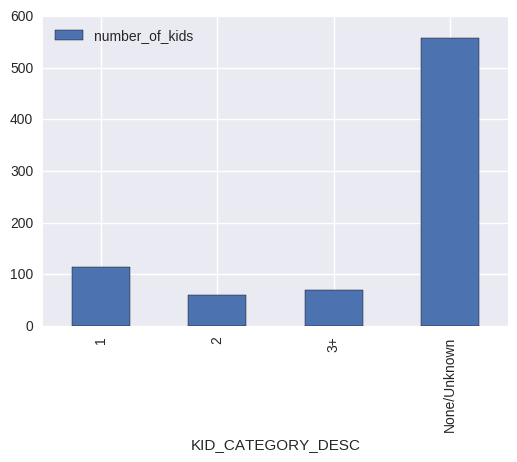

In [58]:
# Number of kids per household

children_dist = demographics[['KID_CATEGORY_DESC', 'household_key']]
children_dist = children_dist.groupby('KID_CATEGORY_DESC').count()
children_dist = children_dist.rename(columns={'household_key':'number_of_kids'})
children_dist.plot(kind='bar')

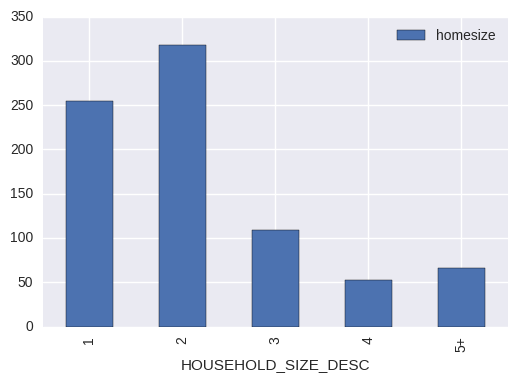

In [59]:
# Household size

homesize_dist = demographics[['HOUSEHOLD_SIZE_DESC', 'household_key']]
homesize_dist = homesize_dist.groupby('HOUSEHOLD_SIZE_DESC').count()
homesize_dist = homesize_dist.rename(columns={'household_key':'homesize'})
homesize_dist.plot(kind='bar')

In [3]:
# Display some dataframes

print "transactions:"
display(transactions.head())
print "demographics:"
HTML(demographics.head().to_html())

transactions:


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


demographics:


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


# Customer segmentation analysis

## Simple Features Engineering

In [4]:
# Merge dataframes on household_key and drop useless features

merged_data = pd.merge(transactions,demographics, on='household_key', how='inner')
merged_data=merged_data.drop(['TRANS_TIME','DAY','WEEK_NO','BASKET_ID','PRODUCT_ID'], axis=1)

In [5]:
# Number of unique STORE_ID
len(np.unique(merged_data.STORE_ID)) 

354

In [6]:
# Transform strings into numerical data

merged_data=merged_data.apply(LabelEncoder().fit_transform)
print merged_data.head()

   household_key  QUANTITY  SALES_VALUE  STORE_ID  RETAIL_DISC  COUPON_DISC  \
0            440         1          226       337         2047          355   
1            440         1          306       337         2004          355   
2            440         1          316       337         2047          355   
3            440         1          257       337         1945          355   
4            440         1           67       337         1965          355   

   COUPON_MATCH_DISC  AGE_DESC  MARITAL_STATUS_CODE  INCOME_DESC  \
0                 63         5                    1            0   
1                 63         5                    1            0   
2                 63         5                    1            0   
3                 63         5                    1            0   
4                 63         5                    1            0   

   HOMEOWNER_DESC  HH_COMP_DESC  HOUSEHOLD_SIZE_DESC  KID_CATEGORY_DESC  
0               0             3           

In [7]:
# Split data into training and testing sets. x is features, y is what we are trying to predict. 

train, test = train_test_split(merged_data, test_size = 0.999)
train_y=train['STORE_ID']
train_x=train.drop('STORE_ID',axis=1)
test_y=test['STORE_ID']
test_x=test.drop('STORE_ID',axis=1)
len(np.unique(train_y)) 

116

## Model training and Cross Validation

In [8]:
# Model training and evaluation using XGBoost

model = XGBClassifier(seed=27, learning_rate=0.5, n_estimators=100, objective = "multi:softmax")
model.fit(train_x, train_y)
print "done"

done


In [9]:
# Cross validation scores

scores = cross_val_score(model, train_x, train_y, cv=5)        
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.41 (+/- 0.06)


## Features importance analysis

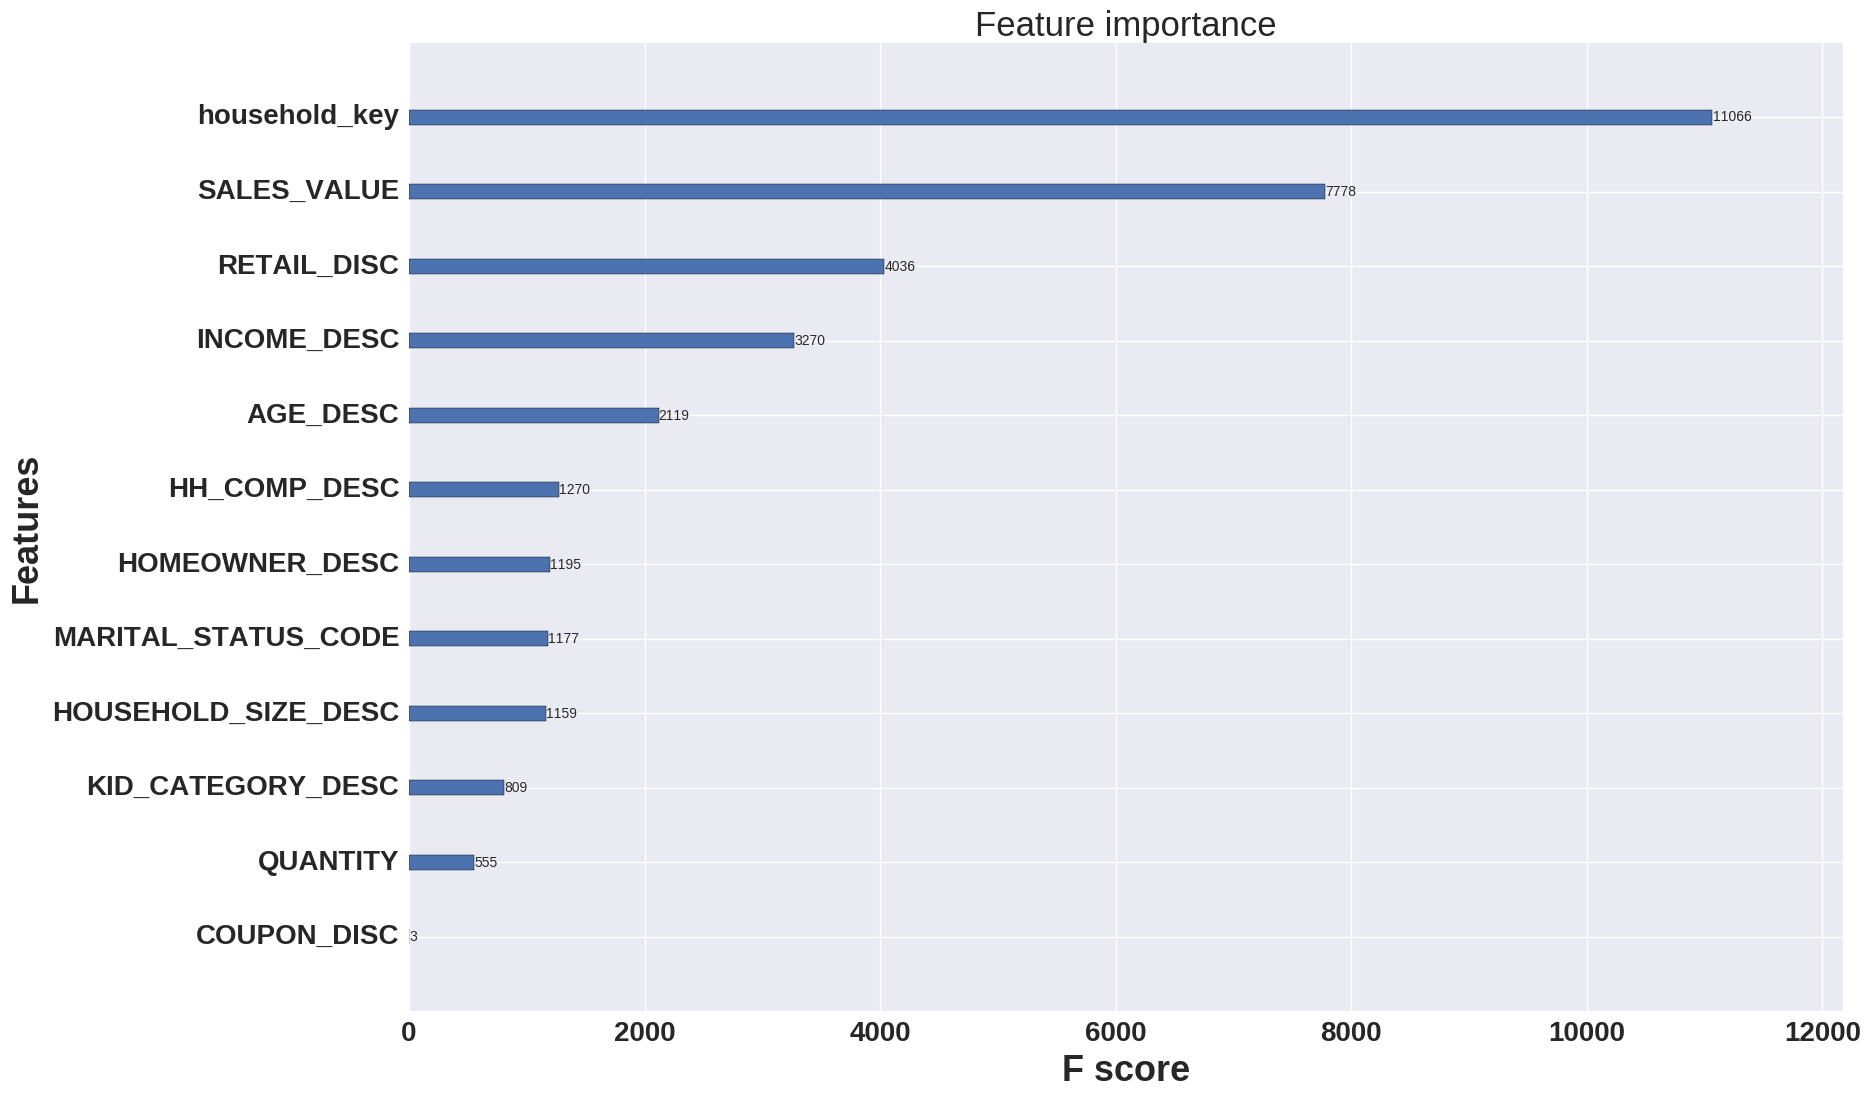

In [61]:
from xgboost import plot_importance
plot_importance(model)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 12.5)
plt.xticks(fontsize = 20, fontweight='bold')
plt.yticks(fontsize = 20, fontweight='bold')

plt.xlabel('F score', fontsize=26, fontweight='bold')
plt.ylabel('Features', fontsize=26, fontweight='bold')
plt.title('Feature importance', fontsize=25)

plt.show()